In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import collections
import uuid
import itertools
import json
import csv
from frgpascal.hardware.sampletray import SampleTray, AVAILABLE_VERSIONS as sampletray_versions
from frgpascal.hardware.liquidlabware import LiquidLabware, AVAILABLE_VERSIONS as liquid_labware_versions
from frgpascal.hardware.hotplate import AVAILABLE_VERSIONS as hotplate_versions
from frgpascal.experimentaldesign.helpers import where_to_store, calculate_mix, build_sample_list, plot_tray
from frgpascal.experimentaldesign.recipes import Solution, Drop, Spincoat, Anneal, Rest, Characterize, Sample
from frgpascal.experimentaldesign.tasks import *
from frgpascal.experimentaldesign.scheduler import Scheduler

In [48]:
ALL_TASKS.keys()

dict_keys(['idle_gantry', 'spincoater_to_hotplate', 'spincoater_to_storage', 'spincoater_to_characterization', 'hotplate_to_spincoater', 'hotplate_to_storage', 'hotplate_to_characterization', 'storage_to_spincoater', 'storage_to_hotplate', 'storage_to_characterization', 'characterization_to_spincoater', 'characterization_to_hotplate', 'characterization_to_storage', 'spincoat', 'anneal', 'rest', 'characterize'])

# Placeholder Workflow

In [49]:
drop = samples[0].worklist[0].drops[0]

In [50]:
solution_details[drop.solution]

{'volume': 160,
 'labware': '96_Plate1',
 'slot': 'A1',
 'initial_volume_required': 160.0}

In [51]:
solution_details

{<Solution>1M MA_Pb_I3 in DMF9_DMSO1: {'volume': 160,
  'labware': '96_Plate1',
  'slot': 'A1',
  'initial_volume_required': 160.0},
 <Solution>Chlorobenzene: {'volume': 560,
  'labware': '4mL_Tray1',
  'slot': 'A1',
  'initial_volume_required': 560.0}}

In [52]:
def handle_liquids(samples, unique_solutions, min_volume=50):
    min_volume = 50
    solution_details = {s:dict(volume=0, labware=None, slot=None) for s in unique_solutions}
    for s in samples:
        for sc in [task for task in s.worklist if isinstance(task, Spincoat)]:
            for d in sc.drops:
                    solution_details[d.solution]['volume'] += d.volume

    for sol, v in solution_details.items():
        v['volume'] = max(min_volume, v['volume'])

    #####
    mixtures = np.array([
        calculate_mix(
            target=solution,
            volume=v['volume'],
            stock_solutions = stock_solutions
        ) for solution, v in solution_details.items()])

    volumes_needed_per_stock = {
        soln: vol for soln,vol in zip(stock_solutions,mixtures.sum(axis=0))}
    for s in solution_details:
        solution_details[s]['initial_volume_required'] = volumes_needed_per_stock.get(s,0)
    #####

    to_be_mixed = {s:v for s,v in solution_details.items() if s not in stock_solutions}

    for ll in solution_storage:
        ll.unload_all()
    for solution, v in solution_details.items():
        volume = max(v['volume'], v['initial_volume_required'])
        ll = where_to_store(volume, solution_storage) #which liquid labware
        slot = ll.load(solution)
        solution_details[solution]['labware'] = ll.name
        solution_details[solution]['slot'] = slot

    for s in samples:
        for task in s.worklist:
            if not isinstance(task, Spincoat):
                continue
            for drop in task.drops:
                d = solution_details[drop.solution]
                drop.solution.well = {
                    'tray': d['labware'],
                    'slot': d['slot'],
                }

    #####
    mixing_netlist = {} #source: {[destinations], [volumes]}
    for target_solution, target_vals in solution_details.items():
        if target_vals['initial_volume_required'] > 0: 
            continue #does not need mixing, comes preloaded, ski
        target_well = f"{target_vals['labware']}-{target_vals['slot']}"
        required_volumes = calculate_mix(
            target=target_solution,
            volume=target_vals['volume'],
            stock_solutions = stock_solutions
        )
        for stock_solution, stock_volume in zip(stock_solutions, required_volumes):
            if stock_volume > 0:    
                stock_v = solution_details[stock_solution]
                source = f"{stock_v['labware']}-{stock_v['slot']}"
                if source not in mixing_netlist:
                    mixing_netlist[source] = dict(destinations=[], volumes=[])
                mixing_netlist[source]['destinations'].append(target_well)
                mixing_netlist[source]['volumes'].append(stock_volume)


    # mixing_netlist = {
    #     source:dict(destinations=[], volumes=[]
    #     for source, v in solution_details.items()
    #     if v['initial_volume_required'] > 0} #source: {[destinations], [volumes]}

    # mixing_netlist = {} #destination: {source, volume}

    # for target, target_v in solution_details.items():
    #     if target in stock_solutions:
    #         continue #stock solution is already made
    #     destination = f"{target_v['labware']}-{target_v['slot']}"
    #     mixing_netlist[destination] = {}
    #     required_volumes = calculate_mix(
    #         target=target,
    #         volume=target_v['volume'],
    #         stock_solutions = stock_solutions
    #     )
    #     for stock, vol in zip(stock_solutions, required_volumes):
    #         if vol > 0:    
    #             stock_v = solution_details[stock]
    #             source = f"{stock_v['labware']}-{stock_v['slot']}"
    #             mixing_netlist[destination][source]=vol
    
    return solution_details, mixing_netlist



        

# Define Labware

## Storage Trays

In [53]:
print('Available Versions:')
for v in sampletray_versions:
    print(f'\t{v}')

Available Versions:
	storage_v1
	storage_v2
	storage_v3


In [54]:
sample_trays = [
    SampleTray(
        name='Tray1',
        version='storage_v1',
        gantry=None,
        gripper=None,
        p0=[0,0,0]
    ),
    SampleTray(
        name='Tray2',
        version='storage_v1',
        gantry=None,
        gripper=None,
        p0=[0,0,0]
    )
]

## Liquid Labware 
Versions are defined by the same json files used to define custom labware for the Opentrons2 liquid handler. 

New labware can be defined by following https://support.opentrons.com/en/articles/3136504-creating-custom-labware-definitions

In [55]:
print('Available Versions:')
for v in liquid_labware_versions:
    print(f'\t{v}')

Available Versions:
	frg_12_wellplate_15000ul
	frg_24_wellplate_4000ul
	frg_spincoater_v1
	greiner_96_wellplate_360ul
	sartorius_safetyspace_tiprack_200ul


Include _all possible_ liquid storage. Later on we will narrow this down to what is required once we know what solutions and volumes we need

In [56]:
solution_storage = [
    LiquidLabware(
        name='96_Plate1',
        version='greiner_96_wellplate_360ul'
    ),
    # LiquidLabware(
    #     name='96_Plate2',
    #     version='greiner_96_wellplate_360ul'
    # ),
    LiquidLabware(
        name='4mL_Tray1',
        version='frg_24_wellplate_4000ul'
    ),

    # LiquidLabware(
    #     name='4mL_Tray2',
    #     version='frg_24_wellplate_4000ul'
    # ),
    LiquidLabware(
        name='15mL_Tray1',
        version='frg_12_wellplate_15000ul'   
    ),
    # LiquidLabware(
    #     name='15m_Tray2',
    #     version='frg_12_wellplate_15000ul'
    # ),
]

#sort by volume,name
solution_storage.sort(key=lambda labware: labware.name)
solution_storage.sort(key=lambda labware: labware.volume)
print('Priority Fill Order:')
for ss in solution_storage: print(ss)

Priority Fill Order:
<LiquidLabware> 96_Plate1, 0.36 mL volume, 96 wells
<LiquidLabware> 4mL_Tray1, 4.0 mL volume, 24 wells
<LiquidLabware> 15mL_Tray1, 15.0 mL volume, 12 wells


## Define Experimental Mesh

Each of the following cells defines one dimension of the experiment. After defining the individual dimensions, a full sample list will be constructed using a user-selected Design of Expeiment (DOE)

### List of unique substrates. 
Eventually these may link to specific sample id's, but for now just set the unique types of substrates used

In [57]:
input_substrates = [
    '2mm_FTO'
]

### List of target solutions to spin cast. 

Solutions are defined using `SolutionRecipe` class instances.

Chemical formula is defined with underscores between each component. If no coefficient is provided, assumes =1. Example:

``` 
SolutionRecipe(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    )
```

In [58]:
target_solutions = [
    Solution(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    # Solution(
    #     solutes='FA_Pb_I3',
    #     solvent='DMF9_DMSO1',
    #     molarity=1
    # ),
    # Solution(
    #     solutes='FA0.25_MA0.75_Pb_I3',
    #     solvent='DMF9_DMSO1',
    #     molarity=1
    # ),
    # Solution(
    #     solutes='FA0.75_MA0.25_Pb_I3',
    #     solvent='DMF9_DMSO1',
    #     molarity=1
    # ),
    # Solution(
    #     solutes='MA0.5_FA0.5_Pb_I3',
    #     solvent='DMF9_DMSO1',
    #     molarity=1
    # ),
]


#### Defining Antisolvents
Antisolvents are also defined using `SolutionRecipe` class instances. Solutes are left empty, and molarity is unused so can be left as 1/whatever number you like.

Example:
``` 
SolutionRecipe(
        solutes='',
        solvent='Chlorobenzene',
        molarity=1
    )
```

Note that these do not have to be stored in a list, as antisolvents are not considered a standalone experimental dimension. We will include these as spincoating parameters, which along with spin speeds etc. form an experimental dimension that can be permuted/whatever

In [59]:
cb_antisolvent = Solution(
            solutes='',
            solvent='Chlorobenzene',
            molarity=1
        )
# ma_antisolvent = SolutionRecipe(
#             solutes='',
#             solvent='MethylAcetate',
#             molarity=1
#         )

### Spincoating Recipes



#### Defining spincoating parameters

Spincoating recipes are defined using the `SpincoatRecipe` object. This consists of a nested list of [speed, acceleration, duration] spin steps. The `SolutionRecipe`, volume, and droptime of both the initial solution and optional antisolvent are also defined. Drop times are relative to t=0. Static spincoating (dispense before spin start) can be achieved by setting a negative number for drop time. Example:

```
SpincoatRecipe(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        solution=SolutionRecipe(...), #this would usually be defined earlier
        solution_volume=100, #uL
        solution_droptime=-5, #seconds relative to start time
        antisolvent=SolutionRecipe(...), #also defined earlier
        antisolvent_volume=50, #seconds relative to start time
        antisolvent_droptime=40,
    )
```

the initial solution is typically left out here, as it will be filled in with the `target_solutions` defined earlier when building the DOE. Example:

```
SpincoatRecipe(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        solution_volume=100, #uL
        solution_droptime=-5, #seconds relative to start time
        antisolvent=SolutionRecipe(...), #also defined earlier
        antisolvent_volume=50, #seconds relative to start time
        antisolvent_droptime=40,
    )
```

In the case that no antisolvent is needed, the three antisolvent terms can be left out.

```
SpincoatRecipe(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        solution=SolutionRecipe(...), #this would usually be defined earlier
        solution_volume=100, #uL
        solution_droptime=-5, #seconds relative to start time
    )
```

In [60]:
spincoat_recipes = [
    Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops = [
            Drop(
                solution='psk_solution',
                volume=20,
                time=5
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                time=40
            )
        ]
    ),

    Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops = [
            Drop(
                solution='psk_solution',
                volume=20,
                time=-1
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                time=40
            )
        ]
    ),
]

In [61]:
spincoat_cb = [
    Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops = [
            Drop(
                solution=cb_antisolvent,
                volume=20,
                time=5
            ),
        ],
        immediate=False
    ),
]

#### Annealing Conditions
Annealing conditions are defined as a list of `AnnealRecipe` class instances. Only two parameters - temperature (C) and duration (s)

Example:
``` 
    AnnealRecipe(
        temperature=100, #degrees C
        duration=60*60, #seconds
    ),
```

In [62]:
anneal_recipes = [
    Anneal(
        temperature=100, #degrees C
        duration=10*60, #seconds
    ),
    Anneal(
        temperature=100, #degrees C
        duration=15*60, #seconds
    ),
]

## Design of Experiment

currently only a full-factorial design is implemented. arguments are lists defined above, and n_repeats is the number of times to repeat each unique combination of conditions

In [63]:
samples = build_sample_list(
    available_trays = sample_trays,
    input_substrates = input_substrates,
    steps = [
        spincoat_recipes,
        anneal_recipes,
        Rest(300),
        Characterize(),
        spincoat_cb,
        Rest(30),
        Characterize(),
    ],
    solution_mesh=dict(
        psk_solution=target_solutions
    ),
    n_repeats=2
)

unique_solutions = list(set([
    d.solution
    for s in samples
    for task in s.worklist if type(task) == Spincoat
    for d in task.drops
]))

print(f'{len(unique_solutions)} unique solutions required across {len(samples)} planned samples')

2 unique solutions required across 8 planned samples


# Preparing the Solutions

## Define Stock Solutions

These are the solutions that you will be mixing to (hopefully) cover your target solutions. If they don't work, the code will tell you, and you can come back to this point and try again.

In [64]:
stock_solutions = [
    Solution(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    Solution(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    Solution(
        solutes='',
        solvent='DMF',
        molarity=1
    ),
    Solution(
        solutes='',
        solvent='DMSO',
        molarity=1
    ),
    Solution(
        solutes='',
        solvent='Chlorobenzene',
        molarity=1
    ),
    Solution(
        solutes='',
        solvent='MethylAcetate',
        molarity=1
    ),
]

Can we cover target solutions with these stocks? and if so, how much of each stock to mix for each target?

In [65]:
solution_details, mixing_netlist = handle_liquids(samples, unique_solutions)

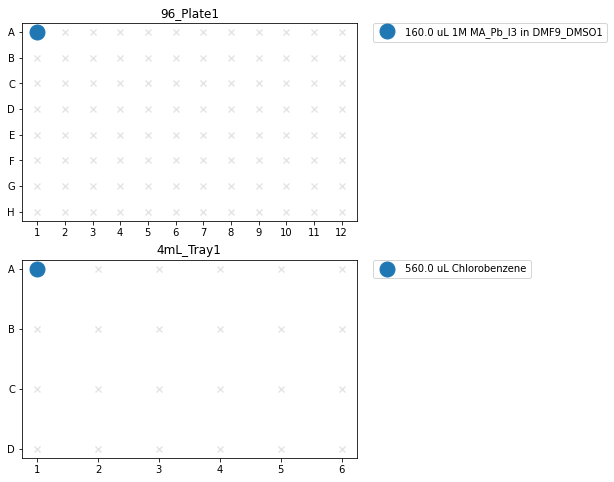

In [66]:
ll_with_solutions = [
    ll for ll in solution_storage
    if len(ll.contents) > 0
]

fig, ax = plt.subplots(len(ll_with_solutions), 1, figsize=(6,4*len(ll_with_solutions)))
try:
    ax = ax.flat
except:
    ax = [ax]
for ll, ax_ in zip(ll_with_solutions, ax):
    ll.plot(solution_details=solution_details, ax=ax_)
plt.savefig("solution_map.jpeg", dpi=150, bbox_inches='tight')

## Build the Experiment Schedule

In [67]:
for s in samples:
    s.tasks = generate_sample_worklist(s)

4


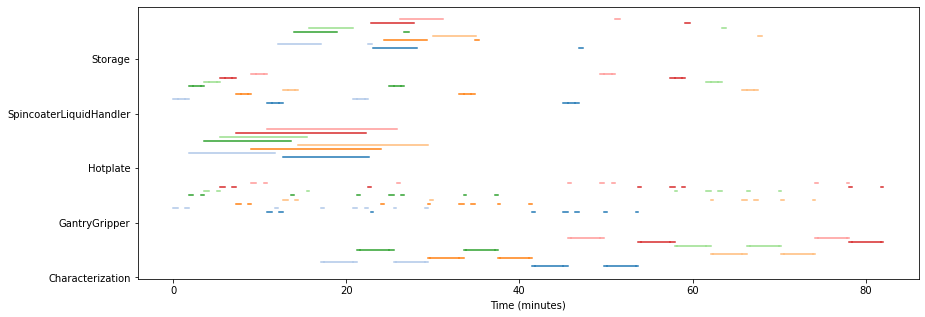

In [69]:
scheduler = Scheduler(
    samples=samples,
    spanning_tasks = ["characterize", "spincoat"], #these tasks spanning each pair must be done in sequence per sample
    enforce_sample_order=False
)
scheduler.solve(10) #argument defines how long (s) to work on finding a solution

In [70]:
ordered_tasks = [
    task
    for sample in samples
    for task in sample.tasks
]
ordered_tasks.sort(key=lambda x:x.start)

In [71]:
gg_tasks = [t for t in ordered_tasks if gg in t.workers]
for precedent, task in zip(gg_tasks, gg_tasks[1:]):
    gantry_idle_time = task.start - precedent.end
    if precedent.task.endswith('to_hotplate') and gantry_idle_time > 10:
        idle_task = Task(
            task='idle_gantry',
            sample=precedent.sample,
            precedents=precedent,
            immediate=True,
            start_time = precedent.end
        )
        idle_task.start = precedent.start+1
        idle_task.end = idle_task.start+idle_task.duration
        ordered_tasks.append(idle_task)

        sample_tasklist = precedent.sample.tasks
        idx = sample_tasklist.index(precedent)
        sample_tasklist.insert(idx+1, idle_task)
        print(f'added idle_gantry between {precedent} and {task} (idle time of {gantry_idle_time} seconds)')
ordered_tasks.sort(key=lambda x:x.start)

# Write final files to disk

## Write mixing netlist to disk, will be copy-pasted into listener.py protocol

In [72]:
with open('ot2netlist.json', 'w') as f:
    json.dump(mixing_netlist, f, indent=4, sort_keys=True)
print('Liquid Handler Netlist String dumped to "ot2netlist.json"')

Liquid Handler Netlist String dumped to "ot2netlist.json"


## Maestro netlist to disk, will be input to maestro to execute experiment

In [76]:
ordered_task_output = [task.to_dict() for task in ordered_tasks]

samples_output = {sample.name:sample.to_dict() for sample in samples}
out = {
    'samples': samples_output,
    'tasks': ordered_task_output,
}
with open('maestronetlist.json', 'w') as f:
    json.dump(out, f, indent=4, sort_keys=True)
print('Maestro Netlist dumped to "maestronetlist.json"')

Maestro Netlist dumped to "maestronetlist.json"


## Solution Instructions to csv, tells operator where/how much to put solutions

In [77]:
with open('stock_solutions.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    header = [
        'Tray',
        'Slot',
        'Volume (uL)',
        'Solutes',
        'Molarity (M)',
        'Solvent',        
    ]
    writer.writerow(header)
    for solution, details in solution_details.items():
        volume = details['initial_volume_required']
        if volume == 0:
            volume = 'Empty Vial'
        line = [
            details['labware'],
            details['slot'],
            volume,
            solution.solutes,
            solution.molarity,
            solution.solvent,
        ]
        writer.writerow(line)